In [1]:
# Script to evaluate a certain pix2pix hyperparameter

import argparse
import os
import random
from ssim.utils import get_gaussian_kernel
import cv2
from ssim import SSIM
from PIL import Image
from utils_stereofog import calculate_model_results, variance_of_laplacian, image_mse, image_ncc, structural_similarity

from general_imports import *

In [2]:
results_paths = ['results/final_models/stereofog_pix2pix',
                 'results/final_models/stereofog_pix2pix_augmented',
                'results/synthetic_datasets/carla_tuebingen_pix2pix',
                'results/synthetic_datasets/cityscapes_tuebingen_pix2pix',
                'results/synthetic_datasets/foggy_cityscapes_pix2pix']

In [57]:
all_laplace_scores = []
all_Pearson_correlation_scores = []
all_MSE_scores = []
all_NCC_scores = []
all_SSIM_scores = []
all_CW_SSIM_scores = []
all_images = []

for results_path in results_paths:
    # Part that needs to be inserted due to the way pix2pix saves the images
    subpath_addition = 'test_latest/images'

    if subpath_addition not in results_path:
        results_path = os.path.join(results_path, f'test_latest/images')

    # ax = [fig.add_subplot(num_models+2,limit,i+1) for i in range(limit*(num_models+2))]

    # ax[0].text(0.5, 1.05, 'fake', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[0].transAxes)
    # ax[1].text(0.5, 1.05, 'foggy real', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[1].transAxes)
    # ax[2].text(0.5, 1.05, 'clear real', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[2].transAxes)

    # CW-SSIM implementation
    gaussian_kernel_sigma = 1.5
    gaussian_kernel_width = 11
    gaussian_kernel_1d = get_gaussian_kernel(gaussian_kernel_width, gaussian_kernel_sigma)

    # Indexing the images
    images = [entry for entry in os.listdir(results_path) if 'fake_B' in entry]
    all_images += [images]
    
    laplace_scores = []
    Pearson_correlation_scores = []
    MSE_scores = []
    NCC_scores = []
    SSIM_scores = []
    CW_SSIM_scores = []

    for i, image in enumerate(images):

        fogged_image_gray = cv2.cvtColor(cv2.imread(os.path.join(results_path, image[:-10] + 'real_A' + '.png')), cv2.COLOR_BGR2GRAY)
        
        laplace_scores.append(variance_of_laplacian(fogged_image_gray))

        clear_image_nonfloat = cv2.imread(os.path.join(results_path, images[i][:-10] + 'real_B' + '.png'))
        fogged_image_nonfloat = cv2.imread(os.path.join(results_path, images[i][:-10] + 'real_A' + '.png'))
        fake_image_nonfloat = cv2.imread(os.path.join(results_path, images[i]))

        # Calculating the Pearson correlation coefficient between the two images (https://stackoverflow.com/questions/34762661/percentage-difference-between-two-images-in-python-using-correlation-coefficient, https://mbrow20.github.io/mvbrow20.github.io/PearsonCorrelationPixelAnalysis.html)
        clear_image_gray = cv2.cvtColor(clear_image_nonfloat, cv2.COLOR_BGR2GRAY)
        fake_image_gray = cv2.cvtColor(fake_image_nonfloat, cv2.COLOR_BGR2GRAY)
        Pearson_image_correlation = np.corrcoef(np.asarray(fake_image_gray), np.asarray(clear_image_gray))
        corrImAbs = np.absolute(Pearson_image_correlation)

        Pearson_correlation_scores.append(np.mean(corrImAbs))

        # Calculating the MSE between the two images
        MSE_score = image_mse(clear_image_gray, fake_image_gray)
        MSE_scores.append(MSE_score)

        # Calculating the NCC between the two images
        NCC_score = image_ncc(clear_image_gray, fake_image_gray)
        NCC_scores.append(NCC_score)

        # Calculating the SSIM between the fake image and the clear image
        (SSIM_score_reconstruction, SSIM_diff_reconstruction) = structural_similarity(clear_image_nonfloat, fogged_image_nonfloat, full=True, multichannel=True, channel_axis=2)
        SSIM_scores.append(SSIM_score_reconstruction)

        # Calculating the CW-SSIM between the fake image and the clear image (https://github.com/jterrace/pyssim)
        CW_SSIM = SSIM(Image.open(os.path.join(results_path, images[i][:-10] + 'real_B' + '.png'))).cw_ssim_value(Image.open(os.path.join(results_path, images[i])))
        CW_SSIM_scores.append(CW_SSIM)

    # Calculate the average values
    mean_laplace = np.mean(laplace_scores)
    mean_Pearson = np.mean(Pearson_correlation_scores)
    mean_MSE = np.mean(MSE_scores)
    mean_NCC = np.mean(NCC_scores)
    mean_SSIM = np.mean(SSIM_scores)
    mean_CW_SSIM = np.mean(CW_SSIM_scores)

    all_laplace_scores += [laplace_scores]
    all_Pearson_correlation_scores += [Pearson_correlation_scores]
    all_MSE_scores += [MSE_scores]
    all_NCC_scores += [NCC_scores]
    all_SSIM_scores += [SSIM_scores]
    all_CW_SSIM_scores += [CW_SSIM_scores]

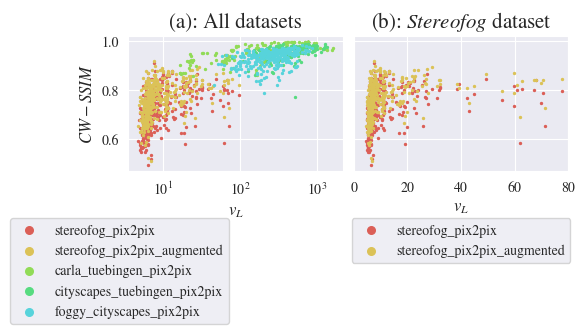

In [8]:
fig, ax = plt.subplots(1,2, figsize=set_size(fraction=0.9, subplots=(1,2)), sharey=True)

for i, results_path in enumerate(results_paths):
    ax[0].scatter(all_laplace_scores[i], all_CW_SSIM_scores[i], label=results_path.split('/')[-1], s=2)
    if 'synthetic' not in results_path:
        ax[1].scatter(all_laplace_scores[i], all_CW_SSIM_scores[i], label=results_path.split('/')[-1], s=2)

legend_left = ax[0].legend(bbox_to_anchor=(0.5, -0.3), loc='upper right')
legend_right = ax[1].legend(bbox_to_anchor=(0.5, -0.3), loc='upper center')

for legend in [legend_left, legend_right]:
    for marker in legend.legend_handles:
        marker._sizes = [30]

# ax[0].set_xlim(-1600)
ax[1].set_xlim(0, 80)

ax[0].set_xscale('log')

ax[0].set_xlabel('$v_L$')
ax[1].set_xlabel('$v_L$')
ax[0].set_ylabel('$CW-SSIM$')
# ax[1].set_ylabel('NCC score')

ax[0].set_title('(a): All datasets', fontsize=15)
ax[1].set_title('(b): $Stereofog$ dataset', fontsize=15)

# plt.suptitle('Laplacian score vs CW-SSIM score')

# plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

# plt.savefig('plots/laplace_vs_SSIM.pdf', format='pdf', bbox_inches='tight')

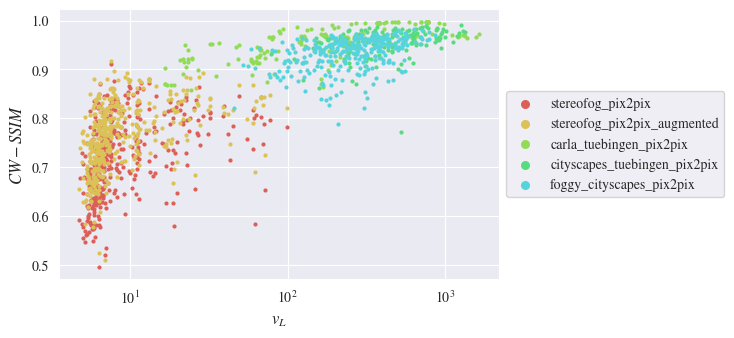

In [19]:
fig, ax = plt.subplots(1,1, figsize=set_size(fraction=0.9))

for i, results_path in enumerate(results_paths):
    ax.scatter(all_laplace_scores[i], all_CW_SSIM_scores[i], label=results_path.split('/')[-1], s=4)

legend = ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

for marker in legend.legend_handles:
    marker._sizes = [30]

ax.set_xscale('log')

ax.set_xlabel('$v_L$')
ax.set_ylabel('$CW-SSIM$')

plt.savefig('plots/laplace_vs_SSIM_semilogx.pdf', format='pdf', bbox_inches='tight')

In [58]:
for index, CW_SSIM_score in enumerate(all_CW_SSIM_scores[0]):
    if f'{CW_SSIM_score:.1f}' == '0.5':
        print(f'Target image with variance of CW-SSIM of 0.5 found with index {index} and file name {all_images[0][index]}.')
        target_image_low_CW_SSIM = all_images[0][index]
        target_image_low_CW_SSIM_index = index
        break

for index, CW_SSIM_score in enumerate(all_CW_SSIM_scores[0]):
    if f'{CW_SSIM_score:.2f}' == '0.91':
        print(f'Target image with variance of CW-SSIM of 0.91 found with index {index} and file name {all_images[0][index]}.')
        target_image_high_CW_SSIM = all_images[0][index]
        target_image_high_CW_SSIM_index = index
        break


Target image with variance of CW-SSIM of 0.5 found with index 48 and file name 2023-08-10_RUN2__12_fake_B.png.
Target image with variance of CW-SSIM of 0.91 found with index 176 and file name 2023-08-16_RUN3__357_fake_B.png.


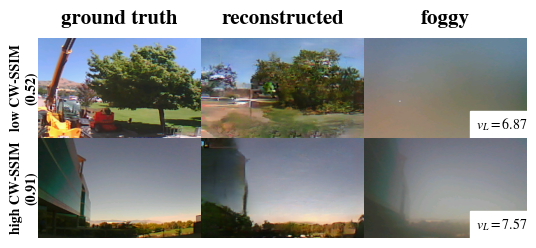

In [98]:
fig, ax = plt.subplots(2,3, figsize=set_size(fraction=1.0, subplots=(2,3)), sharey=True)

ax[0, 0].imshow(plt.imread('results/final_models/stereofog_pix2pix/test_latest/images/'+target_image_low_CW_SSIM.replace('fake_B', 'real_B')), aspect='auto')
ax[0, 0].axis('off')
ax[0, 1].imshow(plt.imread('results/final_models/stereofog_pix2pix/test_latest/images/'+target_image_low_CW_SSIM), aspect='auto')
ax[0, 1].axis('off')
ax[0, 2].imshow(plt.imread('results/final_models/stereofog_pix2pix/test_latest/images/'+target_image_low_CW_SSIM.replace('fake_B', 'real_A')), aspect='auto')
ax[0, 2].axis('off')

ax[1, 0].imshow(plt.imread('results/final_models/stereofog_pix2pix/test_latest/images/'+target_image_high_CW_SSIM.replace('fake_B', 'real_B')), aspect='auto')
ax[1, 0].axis('off')
ax[1, 1].imshow(plt.imread('results/final_models/stereofog_pix2pix/test_latest/images/'+target_image_high_CW_SSIM), aspect='auto')
ax[1, 1].axis('off')
ax[1, 2].imshow(plt.imread('results/final_models/stereofog_pix2pix/test_latest/images/'+target_image_high_CW_SSIM.replace('fake_B', 'real_A')), aspect='auto')
ax[1, 2].axis('off')

plt.subplots_adjust(hspace=0, wspace=0)

ax[0, 0].text(0.5, 1.1, 'ground truth', horizontalalignment='center', verticalalignment='bottom', transform=ax[0, 0].transAxes, fontweight='bold', fontsize=15, backgroundcolor='white', color='black')
ax[0, 1].text(0.5, 1.1, 'reconstructed', horizontalalignment='center', verticalalignment='bottom', transform=ax[0, 1].transAxes, fontweight='bold', fontsize=15, backgroundcolor='white', color='black')
ax[0, 2].text(0.5, 1.1, 'foggy', horizontalalignment='center', verticalalignment='bottom', transform=ax[0, 2].transAxes, fontweight='bold', fontsize=15, backgroundcolor='white', color='black')

ax[0, 0].text(-0., 0.5, f'low CW-SSIM\n({all_CW_SSIM_scores[0][target_image_low_CW_SSIM_index]:.2f})', horizontalalignment='right', verticalalignment='center', ma='center', transform=ax[0, 0].transAxes, fontweight='bold', fontsize=10, color='black', rotation=90)
ax[1, 0].text(-0., 0.5, f'high CW-SSIM\n({all_CW_SSIM_scores[0][target_image_high_CW_SSIM_index]:.2f})', horizontalalignment='right', verticalalignment='center', ma='center', transform=ax[1, 0].transAxes, fontweight='bold', fontsize=10, color='black', rotation=90)


# ax[0, 2].text(1.0, 0.95, f'$CW-SSIM={all_CW_SSIM_scores[0][target_image_low_CW_SSIM_index]:.2f}$', horizontalalignment='right', verticalalignment='top', transform=ax[0, 2].transAxes, fontweight='bold', fontsize=10, backgroundcolor='white', color='black')
ax[0, 2].text(1.0, 0.05, f'$v_L={all_laplace_scores[0][target_image_low_CW_SSIM_index]:.2f}$', horizontalalignment='right', verticalalignment='bottom', transform=ax[0, 2].transAxes, fontweight='bold', fontsize=10, backgroundcolor='white', color='black')

# ax[1, 2].text(1.0, 0.95, f'$CW-SSIM={all_CW_SSIM_scores[0][target_image_high_CW_SSIM_index]:.2f}$', horizontalalignment='right', verticalalignment='top', transform=ax[1, 2].transAxes, fontweight='bold', fontsize=10, backgroundcolor='white', color='black')
ax[1, 2].text(1.0, 0.05, f'$v_L={all_laplace_scores[0][target_image_high_CW_SSIM_index]:.2f}$', horizontalalignment='right', verticalalignment='bottom', transform=ax[1, 2].transAxes, fontweight='bold', fontsize=10, backgroundcolor='white', color='black')

plt.savefig('plots/example_low_high_CW_SSIM.pdf', format='pdf', bbox_inches='tight')